In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from os.path import basename, dirname
from shutil import copyfile

import json
import pickle
from collections import OrderedDict

import torch

In [4]:
os.chdir("..")

In [5]:
from da.fsmt.modeling_fsmt import FSMTForConditionalGeneration
from da.fsmt.tokenization_fsmt import FSMTTokenizer

In [6]:
from collections import defaultdict

In [7]:
# taken from https://github.com/allenai/allennlp/blob/master/allennlp/nn/util.py

def masked_mean(
    vector: torch.Tensor, mask: torch.BoolTensor, dim: int, keepdim: bool = False
) -> torch.Tensor:
    """
    To calculate mean along certain dimensions on masked values
    # Parameters
    vector : `torch.Tensor`
        The vector to calculate mean.
    mask : `torch.BoolTensor`
        The mask of the vector. It must be broadcastable with vector.
    dim : `int`
        The dimension to calculate mean
    keepdim : `bool`
        Whether to keep dimension
    # Returns
    `torch.Tensor`
        A `torch.Tensor` of including the mean values.
    """
    def tiny_value_of_dtype(dtype: torch.dtype):
        if not dtype.is_floating_point:
            raise TypeError("Only supports floating point dtypes.")
        if dtype == torch.float or dtype == torch.double:
            return 1e-13
        elif dtype == torch.half:
            return 1e-4
        else:
            raise TypeError("Does not support dtype " + str(dtype))

    replaced_vector = vector.masked_fill(~mask, 0.0)
    value_sum = torch.sum(replaced_vector, dim=dim, keepdim=keepdim)
    value_count = torch.sum(mask, dim=dim, keepdim=keepdim)
    return value_sum / value_count.float().clamp(min=tiny_value_of_dtype(torch.float))


In [8]:
def get_sent_reps(src, tokenizer_hf, encoder_hf, layer_id=4):
    # tok
    src = tokenizer_hf.batch_encode_plus(
        src,
        padding="longest", 
        return_tensors="pt",
        return_token_type_ids=False,
        return_attention_mask=True
    )
    # res
    for k, v in src.items():
        src[k] = v.to(model_hf.device)
    
    with torch.no_grad():
        res = encoder_hf.forward(**src,
                           return_dict=True,
                           output_hidden_states=True,
                           #output_attentions=True,
                           )
    
    #he = [r.detach().cpu().numpy() for r in res['hidden_states']]
    
    he = res['hidden_states'][layer_id]
    
    he_means = masked_mean(he, src['attention_mask'].unsqueeze(2).bool(), 1)
        
    return he_means.detach().cpu().numpy()

In [9]:
model_name  = 'concat60'    
hf_dir = f"experiments/en_et_{model_name}/hf"

tokenizer_hf = FSMTTokenizer.from_pretrained(hf_dir)
model_hf = FSMTForConditionalGeneration.from_pretrained(hf_dir)
model_hf = model_hf.cuda()
encoder_hf = model_hf.base_model.encoder

In [10]:
data_raw = {}
domain_names = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
for domain_name in domain_names:
    fn = f"experiments/fairseq-data-en-et-{domain_name}-ft/train.en" # TODO: change to train
    with open(fn) as f:
        data_raw[domain_name] = [l[:-1] for l in f.readlines()]

In [10]:
%%time

BATCH_SIZE = 512
LAYER_ID = 4

data_encoded = defaultdict(list)

for domain, data in data_raw.items():
    print(f"Encoding {domain} data...")
    
    it = 0
    for i in range(0, len(data), BATCH_SIZE):
        if it % 100 == 0:
            print(it)
        
        batch = data[i:i+BATCH_SIZE]
        data_encoded[domain].extend(get_sent_reps(batch, tokenizer_hf, encoder_hf, LAYER_ID))

        it += 1

savedir = f"experiments/en_et_{model_name}/internals"
if not os.path.isdir(savedir):
    os.mkdir(savedir)
    
print(f"Saving to {savedir}/sent_means_train.pkl")
with open(f'{savedir}/sent_means_train.pkl', 'wb') as f:
    pickle.dump(data_encoded, f)

Encoding Europarl data...
0
100
200
300
400
500
600
700
800
900
Encoding OpenSubtitles data...
0
100
200
300
400
500
600
700
800
900
Encoding JRC-Acquis data...
0
100
200
300
400
500
600
700
800
900
Encoding EMEA data...
0
100
200
300
400
500
600
700
800
Saving to experiments/en_et_concat60/internals/sent_means_train.pkl
CPU times: user 17min 23s, sys: 5min 4s, total: 22min 27s
Wall time: 22min 33s


# Ecode test and valid

In [21]:
def encode_data_dict(split):
    # split in 'test', 'valid', 'train'
    
    data_dict_raw = {}
    domain_names = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
    for domain_name in domain_names:
        fn = f"experiments/fairseq-data-en-et-{domain_name}-ft/{split}.en"
        with open(fn) as f:
            data_dict_raw[domain_name] = [l[:-1] for l in f.readlines()]
        
    
    BATCH_SIZE = 512
    LAYER_ID = 4

    data_dict_encoded = defaultdict(list)

    for domain, data in data_dict_raw.items():
        print(f"Encoding {domain} data...")

        it = 0
        for i in range(0, len(data), BATCH_SIZE):
            if it % 100 == 0:
                print(it)

            batch = data[i:i+BATCH_SIZE]
            data_dict_encoded[domain].extend(get_sent_reps(batch, tokenizer_hf, encoder_hf, LAYER_ID))

            it += 1

    savedir = f"experiments/en_et_{model_name}/internals"
    if not os.path.isdir(savedir):
        os.mkdir(savedir)
    
    savefile = f"{savedir}/sent_means_{split}.pkl"
    print(f"Saving to {savefile}")
    with open(savefile, 'wb') as f:
        pickle.dump(data_dict_encoded, f)
    
    return data_dict_encoded

In [22]:
encoded_test = encode_data_dict('test')

Encoding Europarl data...
0
Encoding OpenSubtitles data...
0
Encoding JRC-Acquis data...
0
Encoding EMEA data...
0
Saving to experiments/en_et_concat60/internals/sent_means_test.pkl


In [23]:
encoded_valid = encode_data_dict('valid')

Encoding Europarl data...
0
Encoding OpenSubtitles data...
0
Encoding JRC-Acquis data...
0
Encoding EMEA data...
0
Saving to experiments/en_et_concat60/internals/sent_means_valid.pkl


# K-means

In [11]:
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
import scipy.stats as ss

In [12]:
np.random.seed(21)

In [13]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [14]:
all_encoded = []
all_labels = []
for d, v in data_encoded.items():
    all_encoded.extend(data_encoded[d])
    all_labels.extend([d] * len(data_encoded[d]))    

In [15]:
all_encoded = np.array(all_encoded)
all_labels = np.array(all_labels)

In [16]:
%%time

#indices = np.arange(all_encoded.shape[0])
#np.random.shuffle(indices)

#hiddens_shuff = all_encoded[indices]
#labels_shuff = all_labels[indices]

kmeans = KMeans(n_clusters=4, random_state=0, n_init=1).fit(all_encoded)

conf_matrix = pd.crosstab(all_labels, kmeans.labels_)
corr_k = cramers_corrected_stat(conf_matrix)

print(f"Corr k: {corr_k}")
print(conf_matrix)

savedir = f"experiments/en_et_{model_name}/internals"
if not os.path.isdir(savedir):
    os.mkdir(savedir)
    
    
print(f"Saving to {savedir}/kmeans_train.pkl")
with open(f'{savedir}/kmeans_train.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

i = 0
for k,v in data_raw.items():
    fn = f"nmt_labels-{k}.txt"
    np.savetxt(f"{savedir}/{fn}", kmeans.labels_[i:i+len(v)].astype(int), fmt="%i")
    i += len(v)

Corr k: 0.6914882448939277
col_0               0       1       2       3
row_0                                        
EMEA           111514    2120  284892   12014
Europarl         6714  449954    8376   35122
JRC-Acquis      97537   53206  346033    3244
OpenSubtitles   52831   20666    1827  425552
Saving to experiments/en_et_concat60/internals/kmeans_train.pkl
CPU times: user 1min 35s, sys: 568 ms, total: 1min 36s
Wall time: 19.8 s


In [17]:
import seaborn as sns

<AxesSubplot:xlabel='col_0', ylabel='row_0'>

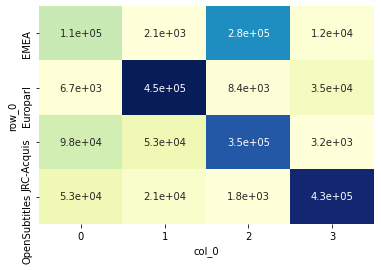

In [18]:
sns.heatmap(conf_matrix,
            cmap="YlGnBu", annot=True, cbar=False)

# Bert sent clusters

In [19]:
labels_bert = {}
domain_names = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
for domain_name in domain_names:
    fn = f"experiments/data-clust/clusters/cl-{domain_name}.en-et.docs.train.clusters_sent_4.txt" # TODO: change to train
    with open(fn) as f:
        labels_bert[domain_name] = [int(l[:-1]) for l in f.readlines()]

In [20]:
labels_bert_all = []
labels_bert_all_true = []
for k,v in labels_bert.items():
    labels_bert_all.extend(v)
    labels_bert_all_true.extend([k] * len(v))

In [21]:
labels_bert_all_true[0:2]

['Europarl', 'Europarl']

In [22]:
conf_matrix = pd.crosstab(np.array(labels_bert_all_true), np.array(labels_bert_all))
corr_k = cramers_corrected_stat(conf_matrix)
print(corr_k)
print(conf_matrix)

0.24168047830449288
col_0               0       1      2       3
row_0                                       
EMEA            72707  140991  39598  157244
Europarl       166334  177192  56586  100054
JRC-Acquis     162534  163134  29920  144432
OpenSubtitles   46245   50394  84391  319846


<AxesSubplot:xlabel='col_0', ylabel='row_0'>

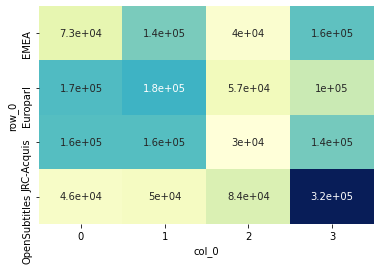

In [23]:
sns.heatmap(conf_matrix,
            cmap="YlGnBu", annot=True, cbar=False)

# BERT doc clusters

In [24]:
labels_bert = {}
domain_names = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
for domain_name in domain_names:
    fn = f"experiments/data-clust/clusters/cl-{domain_name}.en-et.docs.train.clusters_doc_4.txt" # TODO: change to train
    with open(fn) as f:
        labels_bert[domain_name] = [int(l[:-1]) for l in f.readlines()]

In [25]:
labels_bert_all = []
labels_bert_all_true = []
for k,v in labels_bert.items():
    labels_bert_all.extend(v)
    labels_bert_all_true.extend([k] * len(v))

In [26]:
conf_matrix = pd.crosstab(np.array(labels_bert_all_true), np.array(labels_bert_all))
corr_k = cramers_corrected_stat(conf_matrix)
print(corr_k)
print(conf_matrix)

0.8089680719230101
col_0               0       1       2       3
row_0                                        
EMEA            42870  344373    3200   20097
Europarl          521    3372  493821    2452
JRC-Acquis     279334  152902   61959    5825
OpenSubtitles    1001    9881     899  489095


<AxesSubplot:xlabel='col_0', ylabel='row_0'>

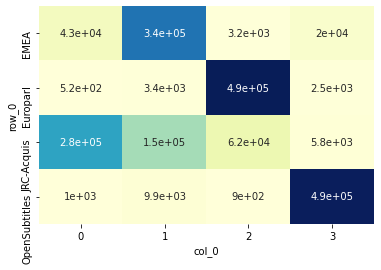

In [27]:
sns.heatmap(conf_matrix,
            cmap="YlGnBu", annot=True, cbar=False)

# Rand clusters

In [28]:
from random import sample

In [29]:
sample??

In [30]:
labels_rand = {}
domain_names = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
for domain_name in domain_names:
    fn = f"experiments/data-clust-new/clusters/cl-{domain_name}.en-et.docs.train.clusters_doc_4.txt" # TODO: change to train
    with open(fn) as f:
        labels_rand[domain_name] = [sample([0,1,2,3], 1)[0] for l in f.readlines()]

In [31]:
labels_rand_all = []
labels_rand_all_true = []
for k,v in labels_rand.items():
    labels_rand_all.extend(v)
    labels_rand_all_true.extend([k] * len(v))

In [32]:
conf_matrix = pd.crosstab(np.array(labels_rand_all_true), np.array(labels_rand_all))
corr_k = cramers_corrected_stat(conf_matrix)
print(corr_k)
print(conf_matrix)

0.00031535624553715905
col_0               0       1       2       3
row_0                                        
EMEA           101931  102400  103079  103130
Europarl       125102  125304  124768  124992
JRC-Acquis     125005  124718  124910  125387
OpenSubtitles  125080  125019  125244  125533


<AxesSubplot:xlabel='col_0', ylabel='row_0'>

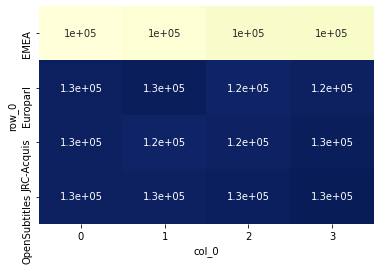

In [33]:
sns.heatmap(conf_matrix,
            cmap="YlGnBu", annot=True, cbar=False)

In [34]:
i = 0
for k,v in data_raw.items():
    fn = f"rand_labels-{k}.txt"
    np.savetxt(f"{savedir}/{fn}", np.array(labels_rand_all)[i:i+len(v)].astype(int), fmt="%i")
    i += len(v)